# Build & Train Classification Model

This notebook will be used to build, train, and test the sample classification model.

# 0. Setup

## 0.1 Import packages

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf

## 0.2 Define test files & constants

In [2]:
PROCESSED_SAMPLES_DIR: str = 'preprocessed_samples_16bit'

Originally, I wanted to train the model to differentiate from all of the following classes, but likely due to a relatively small dataset with very similar features between classes, I was unable to drive accuracy as high as I wanted.

In this project, I will focus only on the percussive classes kick, snare, perc, and cymbal with the goal of achieving accurate differentiation between these classes alone. 

In [3]:
# TEST_808: str = os.path.join(PROCESSED_SAMPLES_DIR, '808_001191.wav')
# TEST_BASS: str = os.path.join(PROCESSED_SAMPLES_DIR, 'bass_001671.wav')
# TEST_CLAP: str = os.path.join(PROCESSED_SAMPLES_DIR, 'clap_001031.wav')
TEST_CYMBAL: str = os.path.join(PROCESSED_SAMPLES_DIR, 'cymbal_001111.wav')
# TEST_GUITAR: str = os.path.join(PROCESSED_SAMPLES_DIR, 'guitar_000921.wav')
# TEST_HAT: str = os.path.join(PROCESSED_SAMPLES_DIR, 'hat_000121.wav')
TEST_KICK: str = os.path.join(PROCESSED_SAMPLES_DIR, 'kick_000751.wav')
TEST_PERC: str = os.path.join(PROCESSED_SAMPLES_DIR, 'perc_000052.wav')
TEST_SNARE: str = os.path.join(PROCESSED_SAMPLES_DIR, 'snare_000741.wav')
# TEST_SYNTH: str = os.path.join(PROCESSED_SAMPLES_DIR, 'synth_003601.wav')
# TEST_VOCAL: str = os.path.join(PROCESSED_SAMPLES_DIR, 'vocal_000151.wav')


In [4]:
SAMPLE_RATE: int = 44100

# 1. Load sample data

## 1.1 Define loading function

In [5]:
def load_audio_sample(file_name):
    file_contents = tf.io.read_file(file_name)

    # Decode audio into mono 
    audio, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # only takes 16bit
    
    # Remove trailing axis
    audio = tf.squeeze(audio, axis=-1)

    return audio

## 1.2 Load and plot test samples

### 1.2.1 Define plotting functions

In [6]:
def plot_sample(audio_sample: tf.Tensor, title: str) -> None:
    plt.plot(audio_sample)
    plt.title(title)
    plt.show()

In [7]:
def load_and_plot_sample(file_path: str) -> None:
    title: str = os.path.basename(file_path)
    plot_sample(load_audio_sample(file_path), title)

### 1.2.2 Plot test samples

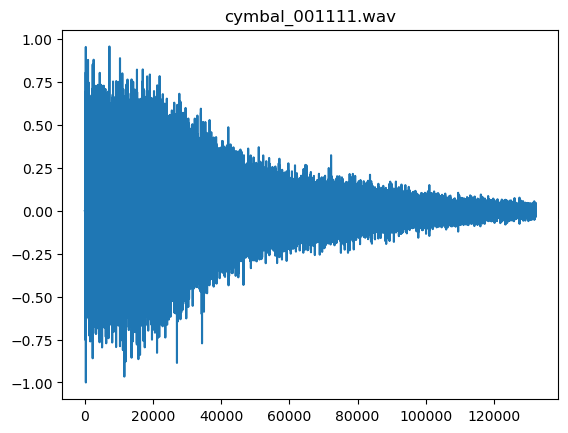

In [28]:
load_and_plot_sample(TEST_CYMBAL)

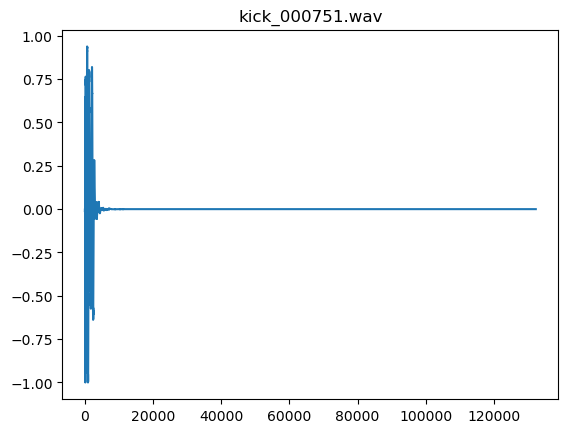

In [26]:
load_and_plot_sample(TEST_KICK)

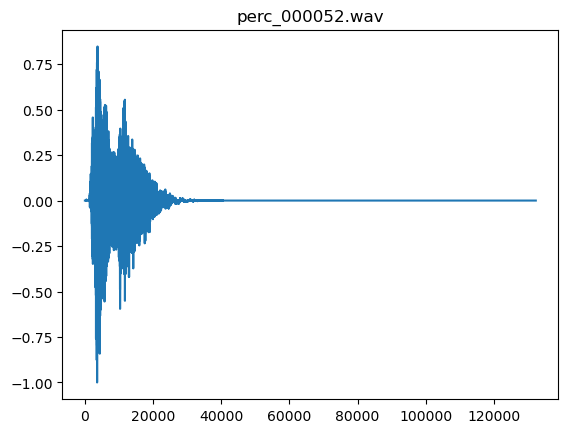

In [29]:
load_and_plot_sample(TEST_PERC)

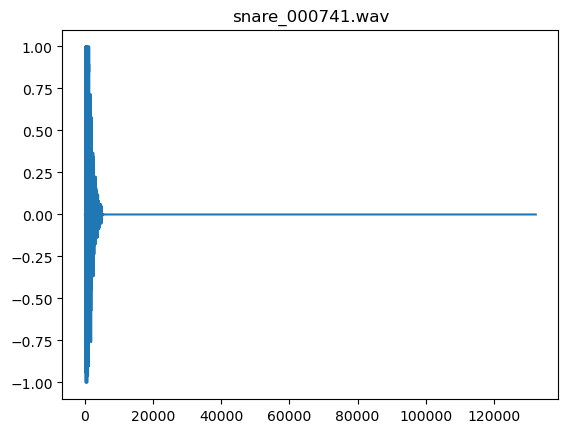

In [30]:
load_and_plot_sample(TEST_SNARE)

# 2. Create Tensorflow Dataset

## 2.1 Create sub-datasets for each class for labeling

In [8]:
# dataset_paths_808: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/808_*.wav', shuffle=False)
# dataset_paths_bass: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/bass_*.wav', shuffle=False)
# dataset_paths_clap: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/clap_*.wav', shuffle=False)
dataset_paths_cymbal: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/cymbal_*.wav', shuffle=False)
# dataset_paths_guitar: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/guitar_*.wav', shuffle=False)
# dataset_paths_hat: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/hat_*.wav', shuffle=False)
dataset_paths_kick: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/kick_*.wav', shuffle=False)
dataset_paths_perc: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/perc_*.wav', shuffle=False)
dataset_paths_snare: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/snare_*.wav', shuffle=False)
# dataset_paths_synth: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/synth_*.wav', shuffle=False)
# dataset_paths_vocal: tf.data.Dataset = tf.data.Dataset.list_files(PROCESSED_SAMPLES_DIR+'/vocal_*.wav', shuffle=False)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-03-03 15:24:27.519096: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-03 15:24:27.519815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
dataset_raw_paths_list: list[tf.data.Dataset] = [
    # dataset_paths_808,
    # dataset_paths_bass,
    # dataset_paths_clap,
    dataset_paths_cymbal,
    # dataset_paths_guitar,
    # dataset_paths_hat,
    dataset_paths_kick,
    dataset_paths_perc,
    dataset_paths_snare
    # dataset_paths_synth,
    # dataset_paths_vocal
]

## 2.2 Create matching labels datasets

In [10]:
dataset_labels_list: list[tf.data.Dataset] = []
for i, dataset in enumerate(dataset_raw_paths_list):
    dataset_labels_list.append(tf.data.Dataset.from_tensor_slices(tf.constant(value=i, dtype=tf.int32, shape=len(dataset))))

## 2.3 Combine lists into path and label datasets

In [11]:
full_path_set = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([], dtype=tf.string))
full_label_set = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor([], dtype=tf.int32))

In [12]:
for path_set in dataset_raw_paths_list:
    full_path_set = full_path_set.concatenate((path_set))

In [13]:
for label_set in dataset_labels_list:
    full_label_set = full_label_set.concatenate((label_set))

## 2.4 One hot encode labels

In [14]:
return_y = lambda y: y
labels_array = np.asarray(list(full_label_set.map(return_y)))

In [15]:
one_hot_label_matrix = tf.keras.utils.to_categorical(labels_array, num_classes=4, dtype='int32') #num_classes changed 11 -> 4

In [16]:
one_hot_label_set: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(one_hot_label_matrix)

## 2.3 Combine paths and labels into master dataset

In [17]:
dataset_paths_labeled: tf.data.Dataset = tf.data.Dataset.zip((full_path_set, one_hot_label_set))

In [41]:
test_sample: tuple[str, list[int]] = dataset_paths_labeled.shuffle(buffer_size=len(dataset_paths_labeled)).as_numpy_iterator().next()
test_sample

(b'preprocessed_samples_16bit/kick_019680.wav',
 array([0, 1, 0, 0], dtype=int32))

# 3. Define function to load samples & apply STFTs

## 3.1 Define function to load a labeled sample

In [18]:
def load_labeled_sample_single(sample: tuple[str, list[int]]) -> tuple[tf.Tensor,tf.Tensor]:
    sample_path, label = sample
    return (load_audio_sample(sample_path), tf.convert_to_tensor(label, dtype=tf.int32))

In [43]:
test_load = load_labeled_sample_single(test_sample)
test_load

(<tf.Tensor: shape=(132300,), dtype=float32, numpy=
 array([ 0.12051392,  0.0501709 , -0.46600342, ...,  0.        ,
         0.        ,  0.        ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 1, 0, 0], dtype=int32)>)

## 3.2 Determine frame size and step for STFT

In [19]:
SAMPLE_LENGTH: int = 132300 # 3sec samples at 44100Hz

In [20]:
FRAME_LENGTH: int = 2**10 # set arbitrarily to find frequency/time resolution balance
FRAME_LENGTH

1024

In [21]:
n_bins: int = int(FRAME_LENGTH / 2 + 1)
n_bins

513

In [22]:
FRAME_STEP: int = int(FRAME_LENGTH / 8)
FRAME_STEP

128

In [23]:
n_frames: int = int(((SAMPLE_LENGTH - FRAME_LENGTH) / FRAME_STEP) + 1)
n_frames

1026

## 3.3 Define function to apply stft & return spectrogram

In [24]:
def transform_audio(audio: tf.Tensor) -> tf.Tensor:
    spectrogram = tf.signal.stft(audio, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP) 
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2) #convolution neural net expects channels dimension
    return spectrogram

## 3.4 Define wrapper function & test

In [25]:
def load_transform_sample(file_path: str, label: list[int]) -> tuple[tf.Tensor, list[int]]:
    return (transform_audio(load_audio_sample(file_path)), label)

### 3.4.1 Test

In [52]:
test_transform = load_transform_sample(test_sample[0], test_sample[1])
test_transform

(<tf.Tensor: shape=(1026, 513, 1), dtype=float32, numpy=
 array([[[3.4021764e+00],
         [4.3351738e+01],
         [1.4690804e+02],
         ...,
         [3.3112064e-02],
         [3.3234272e-02],
         [3.4115791e-02]],
 
        [[1.8662760e+01],
         [6.4187096e+01],
         [1.8904288e+02],
         ...,
         [4.3376159e-02],
         [4.7080319e-02],
         [4.1528702e-02]],
 
        [[2.8599152e+01],
         [8.9424355e+01],
         [2.1618427e+02],
         ...,
         [4.9009126e-02],
         [5.0480098e-02],
         [3.1876564e-02]],
 
        ...,
 
        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],
 
        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],
 
        [[0.0000000e+00],
         [0.0000000e+00],
         [0

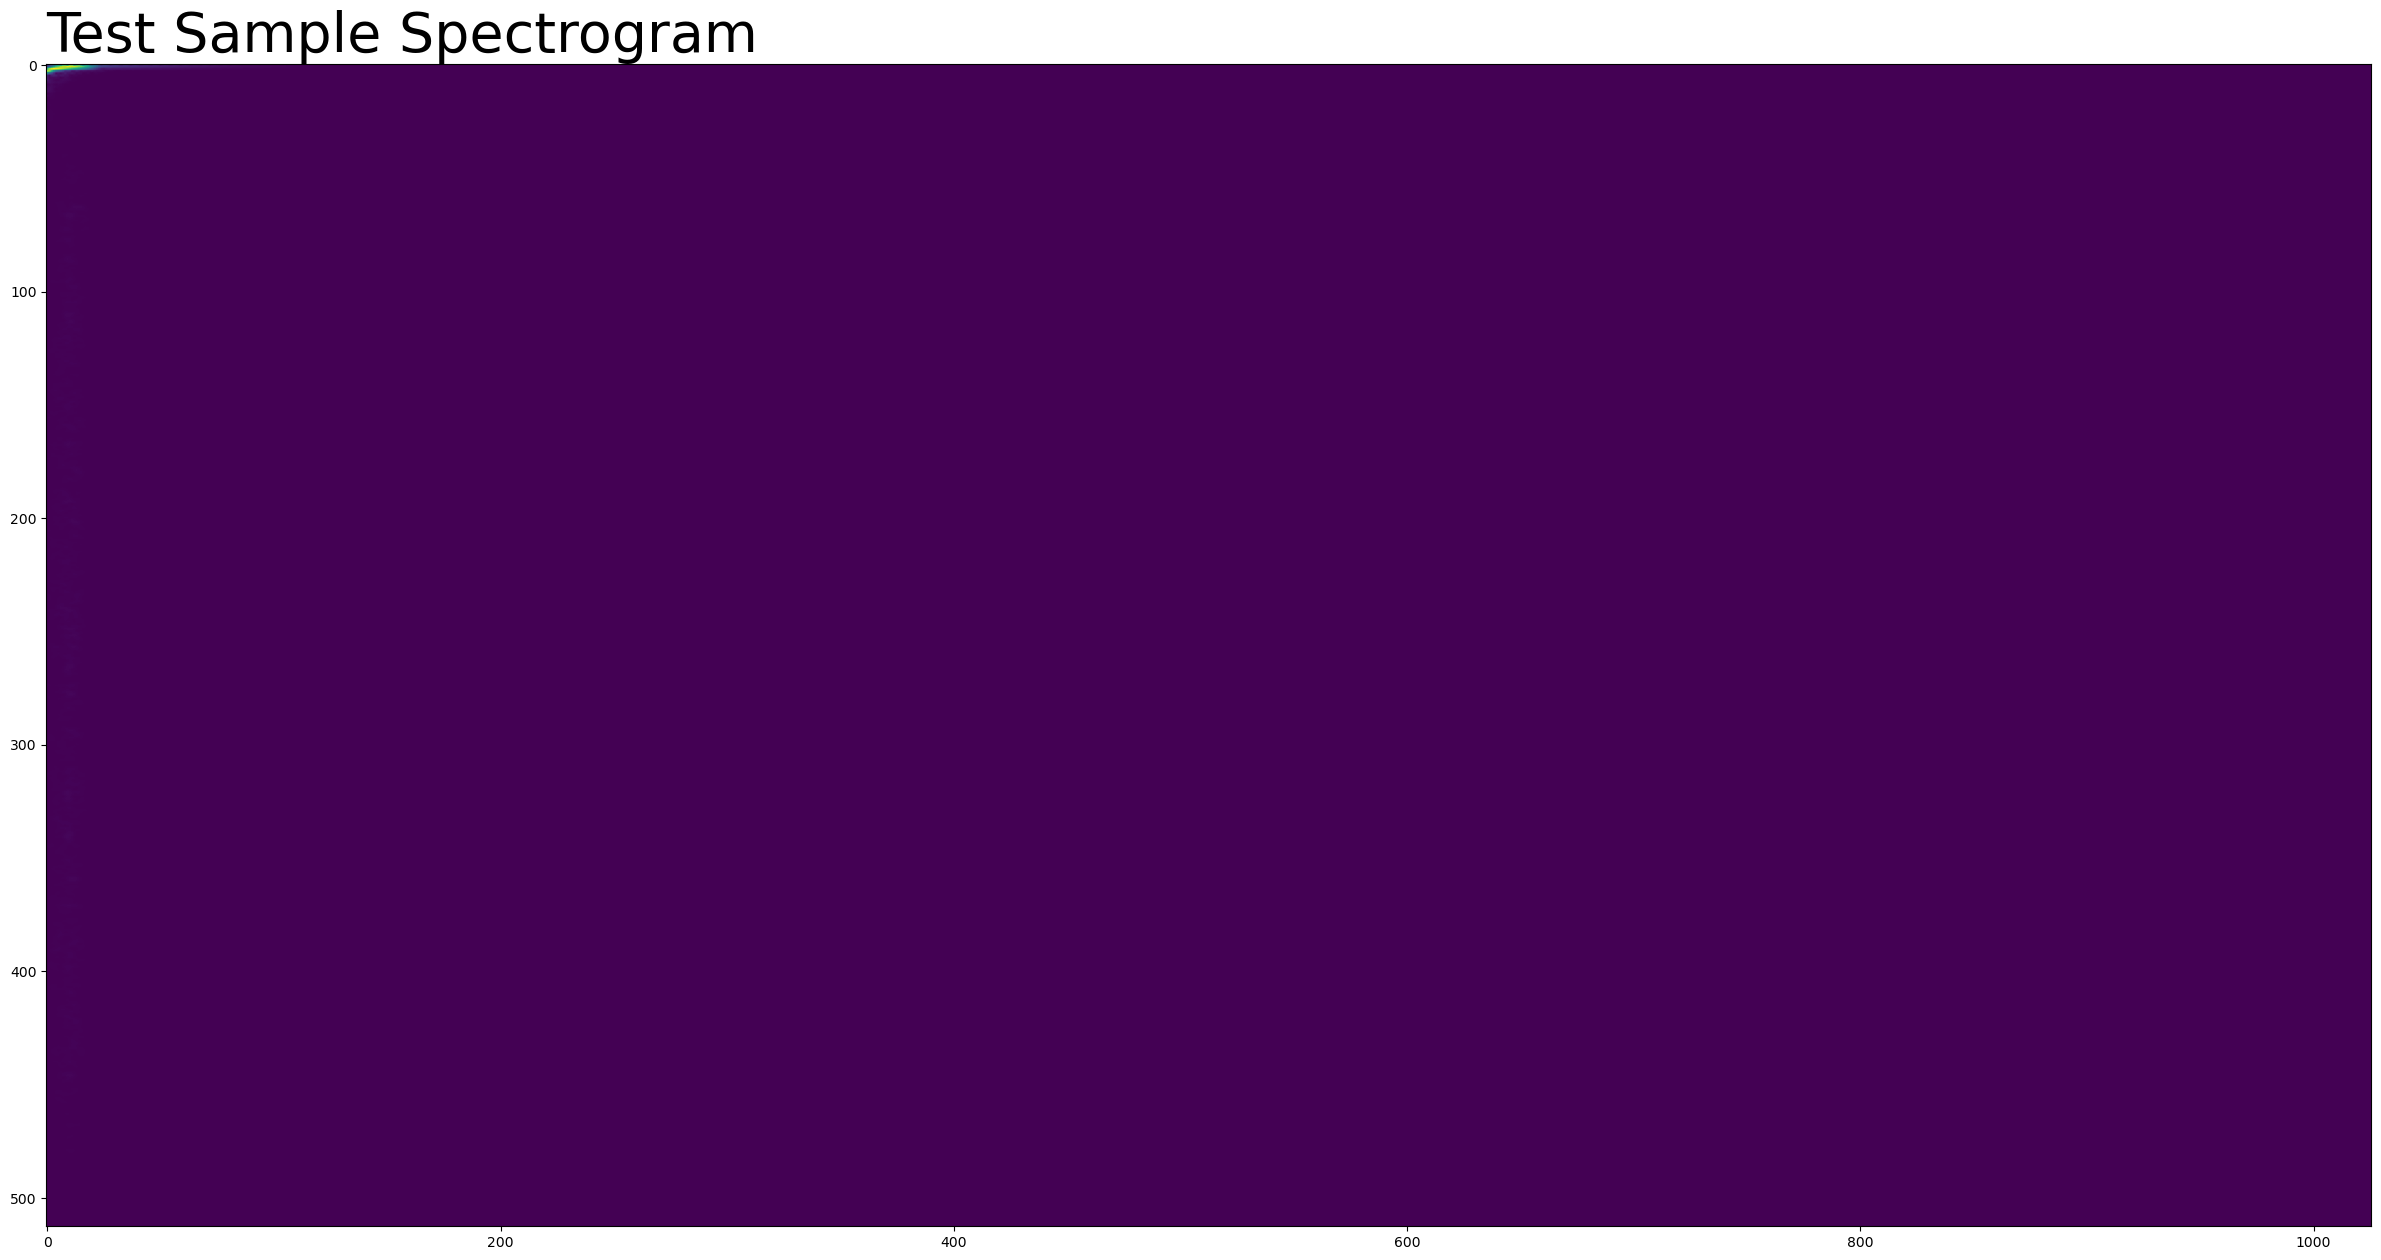

In [53]:
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(test_transform[0])[0])
# plt.yscale('log')
plt.title('Test Sample Spectrogram', fontsize=40, loc='left')
plt.show()

# 4. Process data to prepare for training

## 4.1 Map paths dataset into dataset of labeled spectrograms

In [26]:
spectrograms_labeled: tf.data.Dataset = dataset_paths_labeled.shuffle(buffer_size=len(dataset_paths_labeled)).map(load_transform_sample)

In [27]:
len(spectrograms_labeled)

2076

## 4.2 Prep data and split into train and test sets

In [55]:
processed_dataset: tf.data.Dataset = spectrograms_labeled.cache().batch(32).prefetch(buffer_size=2) # .shuffle(buffer_size=1000)

In [56]:
TRAINING_SPLIT = 0.7 # 70% of the data is used for training, 30% for validation
TRAINING_DATASET_LENGTH = round(len(processed_dataset)*TRAINING_SPLIT)

TESTING_DATASET_LENGTH = len(processed_dataset) - TRAINING_DATASET_LENGTH

In [57]:
training_set: tf.data.Dataset = processed_dataset.take(count=TRAINING_DATASET_LENGTH)
testing_set: tf.data.Dataset = processed_dataset.skip(count=TRAINING_DATASET_LENGTH).take(count=TESTING_DATASET_LENGTH)

### 4.2.1 Check batch

In [58]:
check_training_audio, check_training_label = training_set.as_numpy_iterator().next()

2023-03-03 15:03:03.141717: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-03 15:03:03.300236: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [59]:
check_training_audio

array([[[[7.25757480e-02],
         [3.96057159e-01],
         [1.01519215e+00],
         ...,
         [2.05007056e-03],
         [5.11525897e-04],
         [7.36117363e-05]],

        [[1.54700279e-02],
         [4.43331748e-01],
         [8.01757634e-01],
         ...,
         [2.24526436e-03],
         [4.26560495e-04],
         [1.13248825e-04]],

        [[8.29558372e-02],
         [4.62829143e-01],
         [7.73219228e-01],
         ...,
         [2.67168693e-03],
         [7.99770860e-05],
         [1.74522400e-04]],

        ...,

        [[3.42266783e-02],
         [1.13792077e-01],
         [1.04276784e-01],
         ...,
         [1.31588517e-04],
         [2.68966163e-04],
         [3.60026956e-04]],

        [[5.24574295e-02],
         [8.70999172e-02],
         [5.19496426e-02],
         ...,
         [8.97612335e-05],
         [2.52118218e-04],
         [3.68120149e-04]],

        [[7.92130753e-02],
         [8.97638723e-02],
         [5.96198849e-02],
         ...,
 

In [60]:
check_training_audio.shape

(32, 1026, 513, 1)

In [61]:
check_training_label

array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1]], dtype=int32)

In [62]:
check_training_label.shape

(32, 4)

# 5. Build & train classification model

## 5.1 Load tensorflow dependencies

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters

## 5.2 Build & compile model

In my original design, I implemented a much more complex model, including all of the commented-out layers below. I kept stripping back layers to address overfitting issues until landing on a quite simple structure with only one convolution layer directly to the output.

This simple model fixed my overfitting problem for a few epochs, but overfitting would still ensue quickly and val_accuracy maxed at 75%.

In [69]:
def model_builder(hp: HyperParameters) -> Sequential:

    model = Sequential([
        # convolution layers
        Conv2D(
            hp.Int('conv_1_filters', min_value=16, max_value=64, step=16),
            hp.Choice('conv_1_kernel', values=[3,5]),
            padding='same',
            activation='relu',
            input_shape=(1026, 513, 1)
            # kernel_regularizer='l2',
            # bias_regularizer='l2'
        ),
        BatchNormalization(),
        MaxPooling2D(hp.Int('max_pool_1', min_value=2, max_value=8, step=2)),

        # Conv2D(
        #     hp.Int('conv_2_filters', min_value=16, max_value=64, step=16),
        #     hp.Choice('conv_2_kernel', values=[3,5]),
        #     padding='same',
        #     activation='relu'
        # ),
        # BatchNormalization(),
        # MaxPooling2D(hp.Int('max_pool_2', min_value=2, max_value=8, step=2)),
        
        # Conv2D(
        #     hp.Int('conv_3_filters', min_value=16, max_value=64, step=16),
        #     hp.Choice('conv_3_kernel', values=[3,5]),
        #     padding='same',
        #     activation='relu'
        # ),
        # BatchNormalization(),
        # MaxPooling2D(hp.Int('max_pool_3', min_value=2, max_value=8, step=2)),

        Dropout(hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1)),
        
        # # dense layers
        Flatten(),
        Dense(
            hp.Int('dense_1', min_value=16, max_value=64, step=16),
            activation='relu'    
        ),
        # Dropout(hp.Float('dropout_2', min_value=0, max_value=0.5, step=0.1)),
        # Dense(
        #     hp.Int('dense_2', min_value=16, max_value=64, step=16),
        #     activation='relu'    
        # ),

        # output layer
        Dense(
            4, 
            activation='softmax'
        )
    ])

    # learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])
    learning_rate = 1e-4

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

    

## 5.3 Use Keras Tuner Hyperband to perform hypertuning

In [72]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tmp/model_hypertuning_drums_small',
    project_name='SampleClassifier'
)

In [73]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [74]:
tuner.search(training_set, epochs=40, validation_data=testing_set, callbacks=[stop_early], verbose=1)

Trial 30 Complete [00h 03m 09s]
val_accuracy: 0.7384105920791626

Best val_accuracy So Far: 0.8311258554458618
Total elapsed time: 01h 45m 53s
INFO:tensorflow:Oracle triggered exit


## 5.4 Retrieve best performing hyperparameters

In [75]:
tuner.results_summary(num_trials=3)

Results summary
Results in tmp/model_hypertuning_drums_small/SampleClassifier
Showing 3 best trials
Trial summary
Hyperparameters:
conv_1_filters: 16
conv_1_kernel: 5
max_pool_1: 4
dropout_1: 0.1
dense_1: 48
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8311258554458618
Trial summary
Hyperparameters:
conv_1_filters: 32
conv_1_kernel: 5
max_pool_1: 8
dropout_1: 0.30000000000000004
dense_1: 48
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.8195364475250244
Trial summary
Hyperparameters:
conv_1_filters: 32
conv_1_kernel: 5
max_pool_1: 6
dropout_1: 0.5
dense_1: 32
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8195364475250244


In [76]:
best_hyper_params: HyperParameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [77]:
best_hyper_params.values

{'conv_1_filters': 16,
 'conv_1_kernel': 5,
 'max_pool_1': 4,
 'dropout_1': 0.1,
 'dense_1': 48,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

## 5.5 Retrain model with best hyperparameters & find optimal number of epochs

In [79]:
model = tuner.hypermodel.build(best_hyper_params)

In [80]:
backup = tf.keras.callbacks.BackupAndRestore('tmp/model_fit_backup')

In [81]:
history = model.fit(training_set, epochs=50, validation_data=testing_set, verbose=1, callbacks=[backup])

Epoch 1/50


2023-02-24 22:00:04.361104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.9572 - accuracy: 0.7364

2023-02-24 22:00:25.845975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 28s 592ms/step - loss: 1.9572 - accuracy: 0.7364 - val_loss: 0.8554 - val_accuracy: 0.7384
Epoch 2/50
46/46 [==============================] - 27s 594ms/step - loss: 0.5438 - accuracy: 0.8410 - val_loss: 0.8481 - val_accuracy: 0.7864
Epoch 3/50
46/46 [==============================] - 27s 592ms/step - loss: 0.2916 - accuracy: 0.8967 - val_loss: 0.8977 - val_accuracy: 0.7881
Epoch 4/50
46/46 [==============================] - 27s 591ms/step - loss: 0.2384 - accuracy: 0.9137 - val_loss: 0.8621 - val_accuracy: 0.7781
Epoch 5/50
46/46 [==============================] - 27s 592ms/step - loss: 0.1880 - accuracy: 0.9436 - val_loss: 0.9249 - val_accuracy: 0.7897
Epoch 6/50
46/46 [==============================] - 27s 591ms/step - loss: 0.1575 - accuracy: 0.9538 - val_loss: 1.0287 - val_accuracy: 0.7815
Epoch 7/50
46/46 [==============================] - 27s 592ms/step - loss: 0.1289 - accuracy: 0.9613 - val_loss: 0.8884 - val_accuracy: 0.8113
Epoch 8/50

In [82]:
val_accuracy_per_epoch = history.history['val_accuracy']
best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1 

In [83]:
max(val_accuracy_per_epoch)

0.8592715263366699

In [84]:
best_epoch

19

## 5.6 Retrain hypermodel using optimal epochs

After tuning a few different models of different sizes and letting them run to find the best performance over a number of epochs, I've found the best performance with the medium sized model. We'll reset the tuner to this model's spec and continue training with the optimal number of epochs.

**Best performances**

Small: 86% val_acc @ 19 epochs

Medium: 87% val_acc @ 26 epochs

Large: 84% val_acc @ 22 epochs

In [85]:
# reset tuner to better performing model
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tmp/model_hypertuning_drums_med',
    project_name='SampleClassifier'
)

INFO:tensorflow:Reloading Oracle from existing project tmp/model_hypertuning_drums_med/SampleClassifier/oracle.json
INFO:tensorflow:Reloading Tuner from tmp/model_hypertuning_drums_med/SampleClassifier/tuner0.json


In [86]:
hypermodel = tuner.hypermodel.build(best_hyper_params)

In [87]:
best_epoch = 26

In [88]:
hyper_history = hypermodel.fit(training_set, epochs=best_epoch, validation_data=testing_set, verbose=1, callbacks=[backup])

Epoch 1/26


2023-02-24 22:29:48.437780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.5196 - accuracy: 0.7425

2023-02-24 22:30:09.939925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 28s 593ms/step - loss: 1.5196 - accuracy: 0.7425 - val_loss: 0.8827 - val_accuracy: 0.7533
Epoch 2/26
46/46 [==============================] - 27s 591ms/step - loss: 0.4211 - accuracy: 0.8648 - val_loss: 0.8914 - val_accuracy: 0.7036
Epoch 3/26
46/46 [==============================] - 27s 589ms/step - loss: 0.2584 - accuracy: 0.9171 - val_loss: 0.8205 - val_accuracy: 0.7003
Epoch 4/26
46/46 [==============================] - 27s 591ms/step - loss: 0.1652 - accuracy: 0.9416 - val_loss: 1.0385 - val_accuracy: 0.6474
Epoch 5/26
46/46 [==============================] - 27s 590ms/step - loss: 0.1252 - accuracy: 0.9599 - val_loss: 0.9806 - val_accuracy: 0.6854
Epoch 6/26
46/46 [==============================] - 27s 591ms/step - loss: 0.0891 - accuracy: 0.9769 - val_loss: 0.8924 - val_accuracy: 0.7235
Epoch 7/26
46/46 [==============================] - 27s 594ms/step - loss: 0.0681 - accuracy: 0.9837 - val_loss: 0.8577 - val_accuracy: 0.7930
Epoch 8/26

## 5.7 Evaluate performance

85% accuracy is not ideal for practical applications, but due to the limitations of a small and limited dataset, I'm happy with the results. Greater accuracy could likely be achieved by training on a larger and more sophisticated dataset.

In [89]:
hyper_eval = hypermodel.evaluate(testing_set)

19/19 [==============================] - 5s 263ms/step - loss: 1.3373 - accuracy: 0.8493


## 5.8 Save hypermodel

In [91]:
hypermodel.save('trained_hypermodel')

INFO:tensorflow:Assets written to: trained_hypermodel/assets


INFO:tensorflow:Assets written to: trained_hypermodel/assets
